In [1]:
import datetime
import re
import pandas as pd
import numpy as np


path_311 = "data/311_Service_Requests_from_2010_to_Present.csv"
path_nta = "data/Neighborhood Tabulation Areas.geojson"
path_nta_population = "data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv"

In [2]:
df_311 = pd.read_csv(path_311)

/Users/szalata/anaconda3/envs/ada/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8,17,20,31,32,33,34,35,36,37,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_311.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Agency Name',
       'Complaint Type', 'Descriptor', 'Location Type', 'Incident Zip',
       'Incident Address', 'Street Name', 'Cross Street 1', 'Cross Street 2',
       'Intersection Street 1', 'Intersection Street 2', 'Address Type',
       'City', 'Landmark', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'X Coordinate (State Plane)',
       'Y Coordinate (State Plane)', 'Open Data Channel Type',
       'Park Facility Name', 'Park Borough', 'Vehicle Type',
       'Taxi Company Borough', 'Taxi Pick Up Location', 'Bridge Highway Name',
       'Bridge Highway Direction', 'Road Ramp', 'Bridge Highway Segment',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')

Make sure that "Unique Key" column can be an index

In [4]:
df_311["Unique Key"].is_unique

True

In [5]:
df_311.set_index("Unique Key");

Check what complaint types do not have "Location" set. If there would be few of those or the categories would be of no interest to us, we would have dropped them.

In [6]:
df_311[df_311["Location"].isna()].groupby("Complaint Type").count()["Unique Key"].sort_values()[-20:]

Complaint Type
Housing Options                               18080
Water System                                  19433
DOF Property - Update Account                 21605
DCA / DOH New License Application Request     26243
DHS Advantage -Landlord/Broker                30695
DHS Advantage - Tenant                        40930
DOF Property - Payment Issue                  42306
Housing - Low Income Senior                   51517
HPD Literature Request                        52831
Street Condition                              59336
DOF Property - Request Copy                   61187
DOF Property - Owner Issue                    63830
DOF Parking - Payment Issue                   72491
Maintenance or Facility                       77584
SCRIE                                         87627
DOF Property - Reduction Issue               108468
Benefit Card Replacement                     113956
General Construction/Plumbing                165812
Traffic Signal Condition                     1822

We drop the State Plane coordinates as they are just a different format of the coordinates present in Latitude and Longitude.

In [7]:
df_311.drop(columns=["X Coordinate (State Plane)", "Y Coordinate (State Plane)"], inplace=True)

We drop the "Location" column as it is just the Latitude and Longitude columns combined.

In [8]:
df_311.drop(columns="Location", inplace=True)

# After dropping Location and X/Y Coordinates in State Plane 

We realize that some of the complaint types are incorrct. Many of such entries categories appear only once in the dataset. We drop those entries as we cannot interpret such complaints.

In [9]:
invalid_complaints = list(df_311["Complaint Type"].value_counts(ascending=True)[
    df_311["Complaint Type"].value_counts(ascending=True) == 1].index)
df_311 = df_311[~df_311["Complaint Type"].isin(invalid_complaints)]

## Casting fields to datetime

In [10]:
unique_created_dates = df_311["Created Date"].unique()

In [11]:
unique_closed_dates = df_311["Closed Date"].unique()

In [12]:
unique_closed_dates = list(pd.DataFrame(unique_closed_dates)[0].dropna())

We will verify if the fields with dates have proper formatting. This still does not guarantee that they are logically correct, that is in some expected range, but tells us whether or not we would be able to parse them.

In [13]:
txt='01/17/2026 10:12:35 PM'

# MMDDYYYY 1
re1='((?:[0]?[1-9]|[1][012])[-:\\/.](?:(?:[0-2]?\\d{1})|(?:[3][01]{1}))[-:\\/.](?:(?:[1]{1}\\d{1}\\d{1}\\d{1})|(?:[2]{1}\\d{3})))(?![\\d])'
# White Space 1
re2='( )'	
# HourMinuteSec
re3='((?:(?:[0-1][0-9])|(?:[2][0-3])|(?:[0-9])):(?:[0-5][0-9])(?::[0-5][0-9])?(?:\\s?(?:am|AM|pm|PM))?)'

rg = re.compile(re1+re2+re3,re.IGNORECASE|re.DOTALL)

def try_matching(txt):
    m = rg.search(str(txt))
    if not m:
        print("NOT A MATCH!")
        print(txt)
        return 1
    return 0

In [14]:
mapped_created = list(map(lambda x: try_matching(x), unique_created_dates))
sum(mapped_created)

0

In [15]:
mapped_closed = list(map(lambda x: try_matching(x), unique_closed_dates))
sum(mapped_closed)

NOT A MATCH!
03/30/3027 12:00:00 AM


1

There is one entry among closed dates that is in the third millenium. We assume time travel is impossible, so the complaint couldn't have been closed in the future. Dropping the entry with it.

In [16]:
df_311 = df_311[df_311["Closed Date"] != "03/30/3027 12:00:00 AM"]

Parsing the dates and casting them to pandas datetime type.

In [17]:
df_311["Created Date"] = pd.to_datetime(df_311["Created Date"])

In [18]:
df_311["Closed Date"] = pd.to_datetime(df_311["Closed Date"])

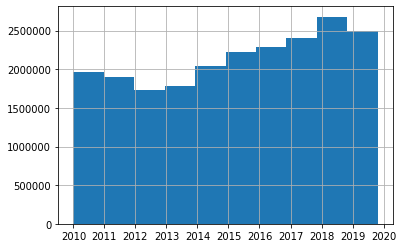

In [36]:
df_311["Created Date"].hist()

We note that the "Created Date" column appears to contain only dates that are possible (within reasonable range. Moreover, we clearly see an increase in the number of complaints overall since the year 2012. This might be either due to growing popularity of 311, increase in population or worsening conditions in the city. It might be a combination of those factors, so we do not draw final conclusions yet.

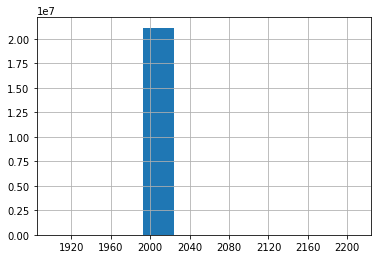

In [20]:
df_311["Closed Date"].hist()

Clearly there is something wrong with the values of ticket closed date. There are entries that have the dates set in 1900s:

In [21]:
df_311[df_311["Closed Date"] < datetime.datetime(2009, 1, 1)].head(2)

Unique Key        Created Date Closed Date Agency  \
333468    32888339 2016-03-13 00:53:20  1900-01-01    DPR   
333501    32888373 2016-03-13 01:03:59  1900-01-01    DPR   

                               Agency Name    Complaint Type       Descriptor  \
333468  Department of Parks and Recreation  New Tree Request  For One Address   
333501  Department of Parks and Recreation  New Tree Request  For One Address   

       Location Type Incident Zip     Incident Address  ... Park Borough  \
333468        Street        11235  4701 BEDFORD AVENUE  ...     BROOKLYN   
333501        Street        11235  2401 EAST 16 STREET  ...     BROOKLYN   

       Vehicle Type Taxi Company Borough Taxi Pick Up Location  \
333468          NaN                  NaN                   NaN   
333501          NaN                  NaN                   NaN   

       Bridge Highway Name Bridge Highway Direction Road Ramp  \
333468                 NaN                      NaN       NaN   
333501                 NaN                      NaN       NaN   

       Bridge Highway Segment   Latitude  Longitude  
333468                    NaN  40.587197 -73.944212  
333501                    NaN  40.592123 -73.954175  

[2 rows x 38 columns]

We assume that those which do not have "Status" set to closed should not have the "Closed Date" set in the first place as the only other status present among them is "Pending". Thus we set their "Closed Date" to NaN. We remove the entries which had the status closed and "Closed date" set before 2010.

In [22]:
df_311[(df_311["Closed Date"] < datetime.datetime(2010, 1, 1)) & (df_311["Status"] == "Closed")]["Unique Key"].count()

101

In [23]:
df_311.drop(df_311[(df_311["Closed Date"] < datetime.datetime(2010, 1, 1)) & (df_311["Status"] == "Closed")].index, inplace=True)

One of the issues we have spotted is the fact that there are entries with "Closed Date" before "Created Date". We assume this might be a way of dealing with complaints submitted for the problems that were already resolved. Those may be also plain mistakes. We decide to drop all such rows.

In [24]:
df_311.drop(df_311[df_311["Closed Date"] < df_311["Created Date"]].index, inplace=True)

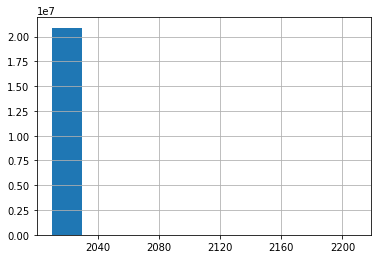

In [25]:
df_311["Closed Date"].hist()

We also decide to remove the rows that have "Closed Date" after today. This is because one expects the tickets with "Closed Date" present to be actually closed already. There is few such cases, so it should not pose a problem.

In [26]:
df_311[df_311["Closed Date"] > datetime.datetime.today()]["Unique Key"].count()

10

In [27]:
df_311.drop(df_311[df_311["Closed Date"] > datetime.datetime.today()].index, inplace=True)

There are two more columns with dates in them:

In [28]:
df_311["Due Date"] = pd.to_datetime(df_311["Due Date"])

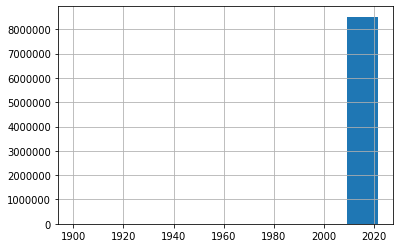

In [29]:
df_311["Due Date"].hist()

We assume that the Due Dates set in 1900s are incorrect and replace them by NaNs.

In [30]:
df_311[df_311["Due Date"] < datetime.datetime(2010, 1, 1)]

Unique Key        Created Date         Closed Date Agency  \
8888713     15639928 2010-01-02 06:23:00 2010-01-12 06:23:00    DEP   
8888714     15656598 2010-01-04 10:39:00 2010-01-14 10:39:00    DEP   
9661308     15658061 2010-01-04 15:01:00 2010-01-04 15:10:00    DEP   
9729742     15640588 2010-01-02 15:20:00 2010-01-02 15:21:00    DEP   
9730009     15640593 2010-01-02 17:49:00 2010-01-04 08:35:00    DEP   
...              ...                 ...                 ...    ...   
11018428    15658164 2010-01-04 12:48:00 2010-01-04 20:51:00    DEP   
11018432    15658169 2010-01-04 13:21:00 2010-01-04 14:20:00    DEP   
11018433    15658170 2010-01-04 13:26:00 2010-01-04 13:35:00    DEP   
11018434    15658171 2010-01-04 13:27:00 2010-01-04 13:35:00    DEP   
11070242    15731459 2010-01-14 12:48:28                 NaT  DOHMH   

                                      Agency Name      Complaint Type  \
8888713    Department of Environmental Protection               Noise   
8888714    Department of Environmental Protection               Noise   
9661308    Department of Environmental Protection        Water System   
9729742    Department of Environmental Protection        Water System   
9730009    Department of Environmental Protection        Water System   
...                                           ...                 ...   
11018428   Department of Environmental Protection        Water System   
11018432   Department of Environmental Protection        Water System   
11018433   Department of Environmental Protection        Water System   
11018434   Department of Environmental Protection        Water System   
11070242  Department of Health and Mental Hygiene  Food Establishment   

                                              Descriptor  \
8888713               Noise: Private Carting Noise (NQ1)   
8888714               Noise: Private Carting Noise (NQ1)   
9661308   Possible Water Main Break (Use Comments) (WA1)   
9729742                        Leak (Use Comments) (WA2)   
9730009                        Leak (Use Comments) (WA2)   
...                                                  ...   
11018428                           Hydrant Leaking (WC1)   
11018432                      Hydrant Running Full (WA4)   
11018433                      Hydrant Running Full (WA4)   
11018434                      Hydrant Running Full (WA4)   
11070242                         Rodents/Insects/Garbage   

                       Location Type Incident Zip        Incident Address  \
8888713                          NaN        10012     209 MULBERRY STREET   
8888714                          NaN        10025    711 AMSTERDAM AVENUE   
9661308                          NaN          NaN                     NaN   
9729742                          NaN          NaN                     NaN   
9730009                          NaN          NaN                     NaN   
...                              ...          ...                     ...   
11018428                         NaN        10451                     NaN   
11018432                         NaN        10022                     NaN   
11018433                         NaN        10022                     NaN   
11018434                         NaN        10022                     NaN   
11070242  Restaurant/Bar/Deli/Bakery        10012  47 EAST HOUSTON STREET   

          ... Park Borough Vehicle Type Taxi Company Borough  \
8888713   ...    MANHATTAN          NaN                  NaN   
8888714   ...    MANHATTAN          NaN                  NaN   
9661308   ...       QUEENS          NaN                  NaN   
9729742   ...       QUEENS          NaN                  NaN   
9730009   ...     BROOKLYN          NaN                  NaN   
...       ...          ...          ...                  ...   
11018428  ...        BRONX          NaN                  NaN   
11018432  ...    MANHATTAN          NaN                  NaN   
11018433  ...    MANHATTAN          NaN                  N

In [31]:
df_311["Due Date"] = df_311["Due Date"].replace(datetime.datetime(1900, 1, 2), np.NaN)

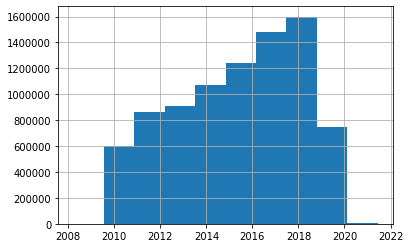

In [32]:
df_311["Due Date"].hist()

In [33]:
unique_resolution_dates = df_311["Resolution Action Updated Date"].unique()

In [34]:
sum(map(lambda x: try_matching(x), unique_resolution_dates))

NOT A MATCH!
nan


1

In [37]:
incorrect_dates = ["10/30/2926 11:51:00 AM", "05/25/2510 10:15:00 AM", "03/06/2927 12:30:00 PM"]

In [38]:
df_311["Resolution Action Updated Date"] = df_311[~df_311["Resolution Action Updated Date"].isin(incorrect_dates)]["Resolution Action Updated Date"]
df_311["Resolution Action Updated Date"] = pd.to_datetime(df_311["Resolution Action Updated Date"])

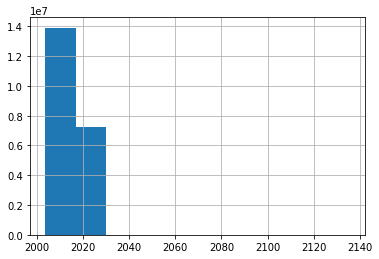

In [39]:
df_311["Resolution Action Updated Date"].hist()

We remove the rows where the Resolution Action Updated Date is in the future. By definition it should be the date when agency has last updated the entry.

In [40]:
df_311.drop(df_311[df_311["Resolution Action Updated Date"] > datetime.datetime.today()].index, inplace=True)

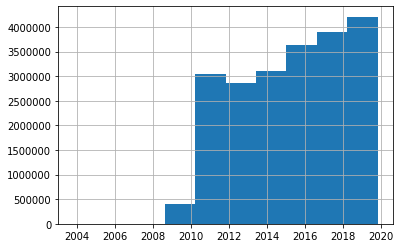

In [41]:
df_311["Resolution Action Updated Date"].hist()

We decide to drop the entries with "Resolution Action Updated Date" before 2010 as that is the date where the data has started being collected.

In [42]:
df_311.drop(df_311[df_311["Resolution Action Updated Date"] < datetime.datetime(2010, 1, 1)].index, inplace=True)

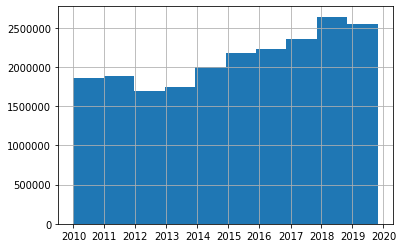

In [43]:
df_311["Resolution Action Updated Date"].hist()

## Casting to "category" type

We note that many of the columns can take only one of a small set of possible values. We cast them to "category" type.

In [44]:
category_columns = ["Agency", "Agency Name", "Complaint Type", "Descriptor", "Location Type",
                    "Community Board", "Address Type", "City", "Landmark", "Facility Type", "Status",
                    "Resolution Description", "Borough", "Open Data Channel Type", "Park Facility Name",
                    "Park Borough", "Vehicle Type", "Taxi Company Borough", "Bridge Highway Direction", "Road Ramp"]

In [45]:
df_311[category_columns] = df_311[category_columns].astype("category")

In [46]:
df_311.to_pickle("data/311_Service_Requests_from_2010_to_Present_small.pkl")

# Wordcloud

In [47]:
# import pandas as pd
# df_311 = pd.read_pickle("data/311_Service_Requests_from_2010_to_Present_small.pkl")

We will generate wordcloud from Complaint Type, Descriptor, and Resolution Descriptor. Those can be narrowed down later.

In [48]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def create_wordcloud(pandas_series, max_words=2000, max_font_size=None, mask=None, word_level=False, filepath=None):
    wordcloud = WordCloud(
        width=3000,
        height=2000,
        max_words=max_words,
        max_font_size=max_font_size,
        background_color='white',
        stopwords=STOPWORDS,
        random_state=1,
        mask=mask,
        contour_width=3,
        contour_color='black'
    )
    
    text = pandas_series.astype(str).values
    processed_text = wordcloud.process_text(" ".join(text))
    wordcloud.generate_from_frequencies(processed_text)
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    if filepath:
        wordcloud.to_file(filepath)

In [49]:
nyc_mask = np.array(Image.open("data/NYC_silhouette.png"))
nyc_mask[nyc_mask > 0] = 255

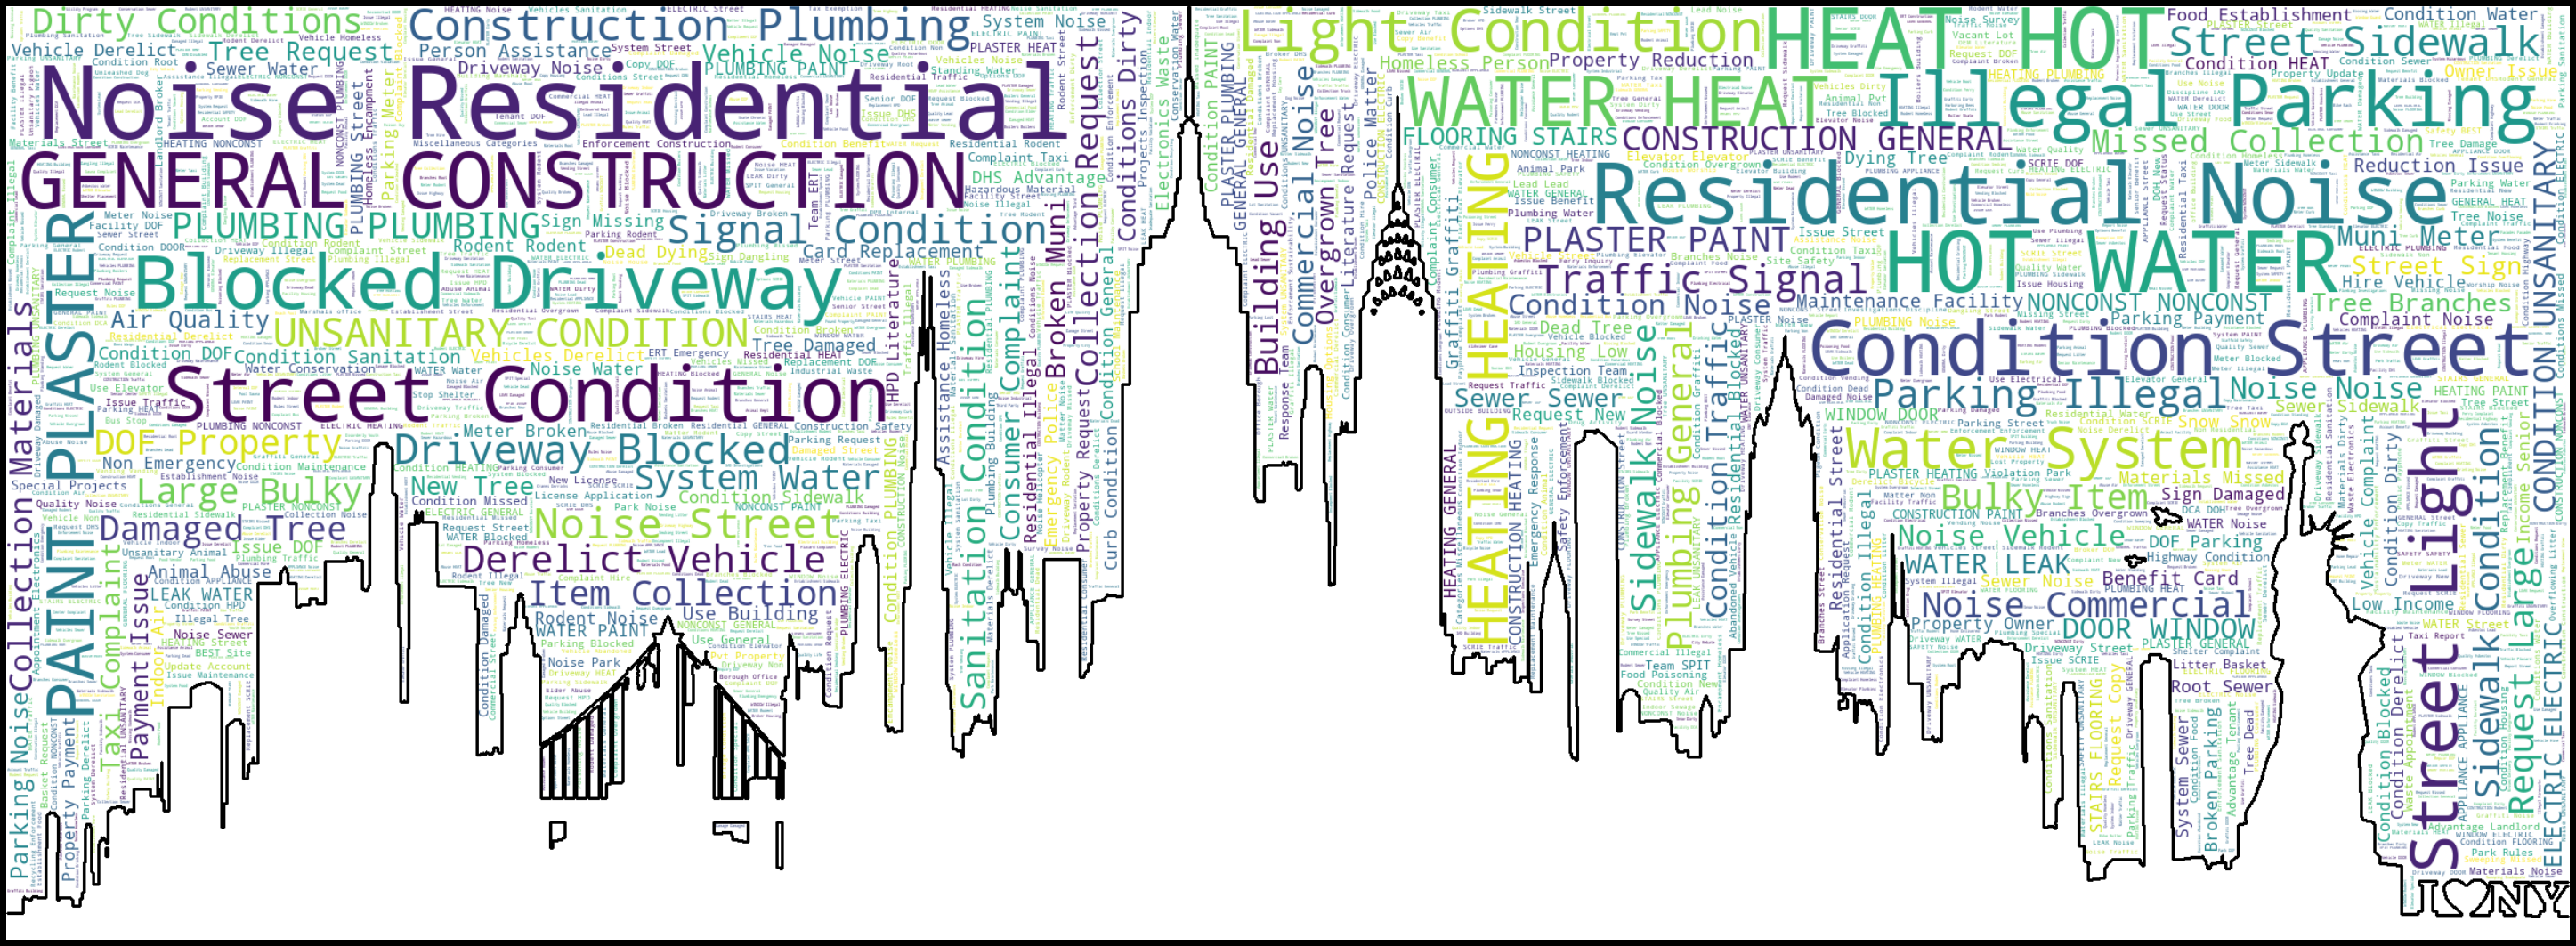

In [50]:
create_wordcloud(df_311["Complaint Type"], mask=nyc_mask, filepath="data/complaint_type_wc.png")

In [ ]:
create_wordcloud(df_311["Resolution Description"], filepath="data/resolution_description_wc.png")

In [ ]:
create_wordcloud(df_311["Descriptor"], filepath="data/resolution_descriptor_wc.png")

# Investigating how agencies are split to take care of smaller regions in NYC

In [55]:
import pandas as pd
df_311 = pd.read_pickle("data/311_Service_Requests_from_2010_to_Present_small.pkl")

In [56]:
school_agencies = [agency for agency in list(df_311["Agency Name"].unique()) if "School - " in agency]
len(school_agencies)

1791

In [57]:
df_311[df_311["Agency Name"].isin(school_agencies)]["Agency"].unique()

[DOE]
Categories (1, object): [DOE]

Many of the agencies are schools. All of them are mapped to agency "DOE". Schools are divided into NYC school districts. The map of such districts is available https://data.cityofnewyork.us/Education/School-Districts/r8nu-ymqj , but we don't see a dataset that could map 3-1-1 Agency Names to school districts.

In [58]:
not_school_agencies = [agency for agency in list(df_311["Agency Name"].unique()) if not "School - " in agency]
len(not_school_agencies)

141

In [59]:
df_311[df_311["Agency"] == "NYPD"]["Agency Name"].unique()

[New York City Police Department, NYPD, Investigation Review Section, Traffic Management Center, New York Police Precinct]
Categories (5, object): [New York City Police Department, NYPD, Investigation Review Section, Traffic Management Center, New York Police Precinct]

We see that a single "Agency" entry maps to multiple "Agency Name" entries that in some cases are equivallent, such as "NYPD" and "New York City Police Department". This indicates that we should first look at the "Agencies" themselves as "Agency Names" may not be meaningful.

In [60]:
list(df_311["Agency"].unique())

['NYPD',
 'DOT',
 'TLC',
 'DSNY',
 'HPD',
 'DEP',
 'DPR',
 'DOHMH',
 'DOB',
 'DHS',
 'DCA',
 '3-1-1',
 'DOITT',
 'DOE',
 'EDC',
 'DFTA',
 'NYCEM',
 'DOF',
 'FDNY',
 'ACS',
 'DCAS',
 'HRA',
 'TAX',
 'DCP',
 'COIB',
 'DVS',
 'TAT',
 'CEO',
 'MOC',
 'OMB',
 'DORIS']

NYPD is split into Police Precints: https://data.cityofnewyork.us/Public-Safety/Police-Precincts/78dh-3ptz

In [61]:
list(df_311[df_311["Agency"] == "OMB"]["Agency Name"].unique())

['OMB']

DSNY (Department of Sanitation) districts: https://data.cityofnewyork.us/City-Government/DSNY-Districts/6j86-5s7z

FDNY (Fire Division). Battallions: https://data.cityofnewyork.us/Public-Safety/Fire-Battalions/uh7r-6nya , divisions (coarse grained): https://data.cityofnewyork.us/Public-Safety/Fire-Divisions/hkpx-aaxc

Overall, we have found geographical subdivisions for DOE, NYPD, DSNY and FDNY.

# Seasonality

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
import pickle as pk
import seaborn as sns
import plotly.graph_objects as go

In [63]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
# with open("data/311_Service_Requests_from_2010_to_Present_small.pkl", 'rb') as f:
#     df_311 = pk.load(f)

In [73]:
df_311['Complaint Type'].cat.remove_unused_categories(inplace=True)
df_311 = df_311.assign(Quantity=pd.Series(np.ones(len(df_311.index))).values)

In [74]:
def plot_season(col="Complaint Type", num_labels=30, plotting="plt", frequency="M", date_grouper="Created Date"):
    if plotting not in ["plt", "plotly"]:
        raise NotImplementedError("Invalid plotting method")
    ### compute complaint types with most occurences
    most_freq_labels = [x for x in df_311[col].value_counts().keys().values[:num_labels]]

    ### group requests by month
    season = df_311.groupby([col, pd.Grouper(key=date_grouper, freq=frequency)])['Quantity']\
        .sum().reset_index().sort_values(date_grouper)
    season.fillna({'Quantity': 0}, inplace=True)


    ### get corresponding times and quantities 
    times = [season[season[col] == c][date_grouper] for c in most_freq_labels]
    qts = [season[season[col] == c]['Quantity'] for c in most_freq_labels]

    ### plot
    if plotting.lower() == "plt":
        plt.figure(figsize=(16,8))
        pal = sns.color_palette("Set1")
        plt.stackplot(times[0], qts, labels=most_freq_labels, colors=pal)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.xlabel("Time")
        plt.ylabel("Count of requests")
        plt.title(col)
        plt.show();
    elif plotting.lower() == "plotly":
        fig = go.Figure({"layout": {"title": {"text": col}}})
        for lab, q, t in zip(most_freq_labels, qts, times):
            fig.add_trace(go.Scatter(
                x=t, y=q,
                hoverinfo='x+y',
                mode='lines',
                name=lab,
                stackgroup='one' # define stack group
            ))
        fig.show()
    else:
        raise NotImplementedError("Woups")

## Plot per complaint type

In [75]:
plot_season('Complaint Type', 100, plotting="plotly")

## Plot per agency

In [ ]:
plot_season("Agency", 20, plotting="plotly")

## Plot per descriptor

In [ ]:
plot_season("Descriptor", 30, plotting="plotly")

## Note
The above plots are extremely useful in notebook format. They allow to zoom, move, scroll, select one or multiple categories,take snapshots,... Sadly, the pictures taken by snapshot are not as flexible: we can't chose the size, have a better view of the axis, not chose the scroll level of the legend, on the right (it's always capped at the top). We tried to make clear snapshots and explain them, but nonetheless apologize for the inconvenience.
## Observations

Around March-April 2014, no more _Heating_ entries are registered, but _HEAT/HOT WATER_ start to appear. It's probable it was replaced.

Heating problems are obviously more reported during winter, peaking between December and January of each year.

![Heat/Hot water](images/heatwater.png)

Tree also had a renaming: _Dead Trees_ to _Dead/Dying Trees_. Apparently, they are different!

![Dead trees](images/deadtree.png)

Similarly, _Street Conditions_ are more reported in spring, around March. 

![Street Conditions](images/streetconditions.png)


Noise knows 2 peaks and 2 pits: the heart of summer and winter seem calmer. Probably because less people are in the street, being mostly on holiday (or inside, during winter). Meanwhile spring and autumn have more people around, creating more nuisance.

![Noise](images/noise.png)


Interestingly, while most of requests are gradually growing (due to the service being more and more popular), some manage to keep a steady level, notably Sewers.

Sewers have another funny feature: August 2011 raises from the usual 2-3k monthly requests to 8k requests. It is possible that the reason for that is a light earthquake, that happend August 22nd, possibly disrupting the sewers system.

![Sewers](images/sewer.png)

Rodent appear mostly during summertime

![Rodents](images/rodent.png)

Illegal parking requests are strongly rising, more than the global rate. This would require additional analysis to draw conclusion, but we can suppose either more people park illegally, or people are specially interested in 3-1-1 as a way to denounce illegal parking.

![Parking](images/illegalparking.png)




# Analysis of noise complaints

In [ ]:
%matplotlib inline

# Imports for this part
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from shapely.geometry import shape, Point

sns.set()

**Noise complaints** being among the most frequent complaints, we do a small analysis of that type of complaints, to get a better understanding of it and be able to re-use general analysis methods for other types of complaints. This analysis is not complete, but shows that we have an improved knowledge of our data, which will allow us to develop robust methods for the upcoming milestone. 

In [ ]:
path_311 = "data/311_Service_Requests_from_2010_to_Present_small.pkl"
path_noise = "data/311_Noise_Complaints.pkl"
path_nta = "data/Neighborhood Tabulation Areas.geojson"
path_nta_population = "data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv"

In [ ]:
# df_311 = pd.read_pickle(path_311)
df_nta_population = pd.read_csv(path_nta_population)

In [ ]:
df_311.head()

In [ ]:
df_311.columns

For the noise complaints analysis we only need a few columns, the rest can be disregarded:

In [ ]:
col_selection = ['Created Date', 'Complaint Type', 'Latitude', 'Longitude']
noise_complaints = df_311[col_selection]

In [ ]:
complaints = df_311["Complaint Type"].unique().tolist()

In [ ]:
complaints_lowercase = list(map(lambda x: (x, x.lower()), complaints))
noise_complaint_types = [complaint[0] for complaint in complaints_lowercase if "noise" in complaint[1]]
print(noise_complaint_types)

In [ ]:
noise_complaint_types = noise_complaint_types[:-1]

In [ ]:
noise_complaints = df_311[df_311["Complaint Type"].isin(noise_complaint_types)]

We focus on noise complaints over a period of 11 weeks, to get more precise information about short-term trends.

In [ ]:
start = datetime(2019, 8, 5)
end = datetime(2019, 10, 21)
noise_complaints = noise_complaints[(start <= noise_complaints["Created Date"]) & (noise_complaints["Created Date"] < end)].reset_index().drop(columns=["index"])

## Add NTA information to complaints

"Neighborhood Tabulation Areas (NTAs) were created to project populations at a small area level, from 2000 to 2030 for PlaNYC, the long-term sustainability plan for New York City. Since population size affects the error associated with population projections, these geographic units needed to have a minimum population, which we determined to be 15,000." [[source]](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-nynta.page)
We have access to the population sizes of the NTAs, and one of our goals was to rank different neighborhoods based on criteria we can extract from the non-emergency 311 requests. Therefore we chose NTAs as the entities we would like to compare, because population sizes must be taken into account when inferring the state of a neighborhood from complaint frequencies.

In [ ]:
print("{:.2f}% of complaints don't have a location".format(100 * (noise_complaints.Latitude.isnull().sum() / noise_complaints.shape[0])))

Less than 2% of noise complaints in the sub-sampled data don't have a location, this is not much and does not need to be addressed.

In [ ]:
# load GeoJSON file containing NTAs
with open(path_nta) as f:
    js = json.load(f)

def get_nta(row):
    """Retrieves the NTA of a given location in NYC.
    Args:
        row: 311 request with associated metadata (e.g. location)
    Returns:
        String: code of the NTA the location is part of, or NaN if the location is not within an NTA
    """
    longitude = row["Longitude"]
    latitude = row["Latitude"]
    point = Point(longitude, latitude)
    for feature in js["features"]:
        polygon = shape(feature["geometry"])
        if polygon.contains(point):
            nta_code = feature["properties"]["ntacode"]
            return nta_code
    return np.nan

In [ ]:
# Add NTA column
noise_complaints["NTA"] = np.nan
noise_complaints.loc[noise_complaints.Latitude.notnull(), "NTA"] = noise_complaints[noise_complaints.Latitude.notnull()].apply(get_nta, axis=1)

Let's first look at the distribution of noise complaints:

In [ ]:
complaint_count = noise_complaints.groupby("Complaint Type") \
                                  .count()["Created Date"] \
                                  .sort_values(ascending=False) 
      
complaint_count = complaint_count[complaint_count != 0]
ax = complaint_count.plot.barh(logx=True, figsize=(15, 10))
ax.set_title("Complaint counts per noise complaint type")
ax.set_xlabel("Count (log scale)");

## Analyse noise based on time of the day

In the **Seasonality** section, we saw that different types of complaints experience different seasonal patterns. Let's see what happens for noise complaints:

In [ ]:
# Add columns for date, weekday and hour of creation
noise_complaints["Created Day"] = noise_complaints["Created Date"].dt.date
noise_complaints["Created Hour"] = noise_complaints["Created Date"].dt.hour
noise_complaints["Created Weekday"] = noise_complaints["Created Date"].dt.dayofweek

In [ ]:
# Use a period of one month for plotting
month_start = datetime(2019, 9, 2)
month_end = datetime(2019, 9, 30)

# Filter complaints and group by the creation date, and distinguish noise complaint types
daily_complaints = noise_complaints[(month_start <= noise_complaints["Created Date"]) & (noise_complaints["Created Date"] < month_end)] \
                            .groupby(['Created Day', 'Complaint Type'])['Created Day'] \
                            .count() \
                            .unstack('Complaint Type') \
                            .fillna(0)

ax = daily_complaints.plot(kind='bar', stacked=True, figsize=(30,10), rot=45)
ax.set_title("Noise complaints over the covered period")
ax.set_xlabel("Hour")
ax.set_ylabel("Count");

Seasonality is obvious, there is a weekly pattern, with a peak in noise complaints over the weekend. 

In [ ]:
hourly_complaints = noise_complaints.groupby(['Created Hour', 'Complaint Type'])['Created Hour'].count().unstack('Complaint Type').fillna(0)
ax = hourly_complaints.plot(kind='bar', stacked=True, figsize=(20,10), rot=0)
ax.set_title("Aggregated noise complaints over the hours of a day")
ax.set_xlabel("Hour")
ax.set_ylabel("Count");

There is also a daily pattern, with lots of noise complaints during the night. We might want to look at the pattern we get when aggregating based on the hour and the weekday, to see if there are differences and validate our current approach (disregard weekday). We expect to have a similar pattern every day, but with different numbers. The previous plots don't really show the relative evolution of the different noise complaints, let's try to normalize complaint counts to get a clearer picture.

In [ ]:
# Normalize hourly noise complaint count
hourly_complaints_normalized = hourly_complaints.div(hourly_complaints.sum(axis=1), axis=0)
ax = hourly_complaints_normalized.plot(kind='bar', stacked=True, figsize=(20,10), rot=0)
ax.set_title("Normalized noise complaint contributions over the hours of a day")
ax.set_xlabel("Hour")
ax.set_ylabel("Normalized contribution");

Within the noise complaint category, we can distinguish between night-time and day-time complaints as follows:
- Day-time: Noise, Noise - Helicopter, Noise - House of Worship, Noise-Park, Noise - Vehical
- Night-time: Noise - Residential, Noise - Street/Sidewalk

So far we assumed that the distribution of noise complaints does not depend on the weekday, let's check if that assumption is true, by plotting the complaint distribution for every weekday:

In [ ]:
hourly_complaints = noise_complaints.groupby(['Created Weekday', 'Created Hour'])[['Created Date']].count().reset_index()

In [ ]:
g = sns.catplot(x='Created Hour', y='Created Date', col='Created Weekday', data=hourly_complaints, kind='bar', col_wrap=2, sharey=False, height=4, aspect=2)
g = g.set_ylabels("Count")

The shapes are not really that different, there are just peaks on Friday and Saturday night that must be taken into account and have an effect on the last 3 plots. The following question arises: is it just party-related / nightly complaints that are responsible for the weekend peaks? The following plot tries to provide an answer to that question, by looking at the distribution of noise complaints over the weekdays, for every hour of the day:

In [ ]:
g = sns.catplot(x='Created Weekday', y='Created Date', col='Created Hour', data=hourly_complaints, kind='bar', col_wrap=2, sharey=False, height=4, aspect=2)
g = g.set_ylabels("Count")

Not only are there more night-time noise-complaints on the weekend, there are also more day-time complaints, probably because people tend to be at home over the weekend, where they are more likely to be disturbed than at work. We notice that night-time complaints contribute a lot to the weekend-peak, this can be seen on the Friday evening/Saturday morning and Saturday evening/Sunday morning plots. 

This kind of behavior is something that should also be taken into account when **reasoning about other types of complaints**, i. e. when interpretating a number of complaints we should always think about factors like the weekday, the hour, etc.

## Analyse noise based on location

We want to identify noisy NTAs. This is a first step to ranking the neighborhood tabulation areas, i. e. noise could be one of the criteria.

Load NTA population sizes:

In [ ]:
nta_pop_df = pd.read_csv(path_nta_population)
nta_pop_df = nta_pop_df[nta_pop_df.Year == 2010].reset_index()

A naive approach would only look at the total number of noise complaints of a NTA, but a more sensible way of measuring the exposure to noise would be to normalize the number of noise complaints, using the population size of the NTA. 

In [ ]:
nta_complaints = noise_complaints.groupby("NTA")[["Created Date"]] \
                                 .count() \
                                 .rename(columns={"Created Date": "Count"})

nta_complaints_extended = nta_complaints.merge(nta_pop_df.set_index("NTA Code"), left_index=True, right_index=True)
nta_complaints_extended["Normalized Count"] = nta_complaints_extended["Count"] / nta_complaints_extended["Population"]
nta_complaints_extended.loc[nta_complaints_extended.Population == 0, "Normalized Count"] = np.nan
nta_complaints_extended = nta_complaints_extended.reset_index().set_index("NTA Name").drop(columns=["level_0"])
nta_complaints_extended.head()

In [ ]:
nta_complaints_extended[["Normalized Count", "Population"]].sort_values(by="Normalized Count", ascending=False).head(10)

Some NTAs correspond to parks or an airport, and have a much smaller population than the other NTAs.

In [ ]:
nta_complaints_extended[nta_complaints_extended.Population < 10000]

Here we compare the NTAs, sorted by the total number of noise complaints, and look at their normalized count rank (`NC Rank` in this dataframe), which is defined as the rank when comparing normalized complaint counts (1 corresponds to the highest normalized count):

In [ ]:
nta_complaints_extended["NC Rank"] = nta_complaints_extended["Normalized Count"].rank(method="min", ascending=False)
nta_complaints_extended[["Count", "Population", "NC Rank"]].sort_values(by="Count", ascending=False).head(10)

## Classifing Complaints

For our next part, we load a subsample of a dataset as to produce visualisations that are statistically representative of the whole dataset. This can quickly be swapped for the entire dataset if needed. 

In [ ]:
import json
import pandas as pd

# Loading sample, and then sub-sampling it because my machine is bad
SAMPLE_PATH = "data/extract.csv"
path_nta = "data/Neighborhood Tabulation Areas.geojson"
path_nta_population = "data/New_York_City_Population_By_Neighborhood_Tabulation_Areas.csv"
df_sample = pd.read_csv(SAMPLE_PATH)
# Here I subsample the dataset to be able to run the rest, please remove
df_sample = df_sample.sample(5000)
df_sample["Complaint Type"].head()

A human will see that many complaint types are related to each other, and could be grouped in categories. This is preciselly what we have done, by classifying our complaint types in complaint type classes, as defined below:

In [ ]:
with open("complaint_type_cls_legend.json") as fp_legend:
    ct_legend = json.load(fp_legend)
ct_legend

The classes are defined as follows:
- **noise annoyance** aggregates 311 complaints about unwanted noises
- **private property condition** aggregates complaints about the degradation or distrubance caused by private property, specifically immovable objects such as Building Condition, Plumbing, Electrical, etc.
- **public utility condition** aggregates complaints about the degradation or distrubance caused by public infrastructure of New York City. This contains Bus Stop Shelter Complaint, Public Payphone Complaint, DEP Street Condition, etc.
- **human activity disturbance** aggregates those complaints that are not due to property but instead by human activity such as Illegal Parking, Taxi Complaint, Consumer Complaint, etc.
- **pest** aggregates those compaints that are due to animals (but not kept as pets).
- **taxation or advantage program related** aggregates those complaints that are administrative in nature, such as DCA / DOH New License Application Request, DOF Property - Payment Issue, DOF Property - Request Copy, etc.
- **general/miscellaneous** compiles the remaining complaints too general to classify in the previous categories

We load the classification that is serliazed within a json file.

In [ ]:
with open("complaint_type_cls.json") as fp_data:
    ct_data = json.load(fp_data)
ct_data

We augment our dataset with the Complaint Type Class of each sample, by inverse mapping with our legend

In [ ]:
df_sample["Complaint Type Class Index"] = df_sample["Complaint Type"].apply(lambda k: ct_data[k])
ct_legend_inv = {v:k for k, v in ct_legend.items()}
df_sample["Complaint Type Class"] = df_sample["Complaint Type Class Index"].apply(lambda k: ct_legend_inv[k])
df_sample.head()

Let's visualize the current distribution of Complaint Type Classes:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 5))
ctc_vcounts = df_sample["Complaint Type Class"].value_counts()
ax = sns.barplot(x=ctc_vcounts.index, y=ctc_vcounts.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=33)

ax

We observe the largest class of complaints are related to private property condition, followed by the 3 big classes that are: public utility condition, human activity disturbance and noise annoyance. The smallest 3 classes are general complaints, related to taxation or social programs, and pests. 

## Geographical representation of Complaints

The main goal of performing this classification is to aggregate related complaints to visualize on a map. The following defines functions to map samples with NTAs that match some test:

In [ ]:
import folium
import json
from shapely.geometry import shape, Point

path_nta = "data/Neighborhood Tabulation Areas.geojson"

# load GeoJSON file containing NTAs
with open(path_nta) as f:
    js = json.load(f)

def get_nta(location):
    """Retrieves the NTA of a given location in NYC.
    Args:
        location_str (String): location associated to the complaint, that is '(latitude, longitude)'
    Returns:
        String: code of the NTA the location is part of, or NaN if the location is not within an NTA
    """
    #location = eval(location_str)
    latitude = location[0]
    longitude = location[1]
    point = Point(longitude, latitude)
    for feature in js["features"]:
        polygon = shape(feature["geometry"])
        if polygon.contains(point):
            nta_code = feature["properties"]["ntacode"]
            return nta_code
    return np.nan


def get_df_ntadist(complaint_type_class):
    test = df_sample["Complaint Type Class"] == complaint_type_class
    return pd.DataFrame(df_sample[test].groupby("NTA").count()["Unique Key"])


def map_df_ntadist(df_ntadist, geojson):
    m = folium.Map(location=(40.730610, -73.935242), zoom_start=10)

    for feature in geojson["features"]:
        #print(feature["properties"]["ntacode"])
        nta_code = feature["properties"]["ntacode"]
        color = df_ntadist.loc[nta_code]["color"] if nta_code in df_ntadist.index else "#000000"
        #print(color)
        feature["properties"]["color"] = color
        gj = folium.GeoJson(feature, name=feature["properties"]["ntaname"],
                           style_function=lambda feature: {
            'color': "#777777",
            'fillColor' : feature["properties"]["color"],
            'weight' : 1,
            'fillOpacity' : 0.66,
            })
        print
        folium.Popup(feature["properties"]["ntaname"] + '\n' + nta_code + '\n' + str(color)).add_to(gj)
        gj.add_to(m)

    return m


We need to zip our Lat/Lon features as Position and find which NTA they are a contained within:

In [ ]:

df_sample["Position"] = list(zip(df_sample["Latitude"], df_sample["Longitude"]))
df_sample["NTA"] = df_sample["Position"].apply(lambda x: get_nta(x))


We also define a COLOR scale to show intensity with 15 steps:

In [ ]:
COLORS = {
    15: "#ff0000",
    14: "#ee0000",
    13: "#dd0000",
    12: "#cc0000",
    11: "#bb0000",
    10: "#aa0000",
    **{k:"#"+str(k)*2+"0000" for k in range(10)}}
COLORS

The get_interp method will make a function to project values between _min and _max as a float between 0 and 15, with 15 when it is maximum and 0 when it is minimum. We also load our geojson file containing NTA polygon data.

In [ ]:
get_interp = lambda _min, _max: lambda v: (v-_min)/(_max-_min)*15

with open("data/Neighborhood Tabulation Areas.geojson") as fp:
    geojson = json.load(fp)

Now we can see the extent of the pest problem in New York City:

In [ ]:

df_ntadist = get_df_ntadist("pest")
MIN = df_ntadist["Unique Key"].min()
MAX = df_ntadist["Unique Key"].max()
df_ntadist["min-max-interp"] = df_ntadist["Unique Key"].apply(get_interp(MIN, MAX)).astype(int)
df_ntadist["color"] = df_ntadist["min-max-interp"].map(COLORS)
df_ntadist.head()

map_df_ntadist(df_ntadist, geojson)

For example we can also see the extent of the noise annoyance in New York City:

In [ ]:


df_ntadist = get_df_ntadist("noise annoyance")
MIN = df_ntadist["Unique Key"].min()
MAX = df_ntadist["Unique Key"].max()
df_ntadist["min-max-interp"] = df_ntadist["Unique Key"].apply(get_interp(MIN, MAX)).astype(int)
df_ntadist["color"] = df_ntadist["min-max-interp"].map(COLORS)
df_ntadist.head()

map_df_ntadist(df_ntadist, geojson)



From those two single maps, we can say that the pest problem appears more specific in which NTAs it targets, where the noise is more diffuse of a problem. One particularly infested neighborhood would appear to be Prospect Heights/Crown Heights in Brooklyn, or Chinatown/Little Italy in Manhattan. According to this news article, this is consistent with reality:

https://patch.com/new-york/new-york-city/these-are-nycs-most-rat-infested-neighborhoods-0

On the other hand, a particularly noisy neighborhood which doesn't appear to have a pest problem is Flatbush in Brooklyn. A testimony can be found online to show that this seems also consistent with reality:

https://www.nydailynews.com/new-york/brooklyn/noise-wars-east-flatbush-sapartment-building-grab-broom-pound-ceiling-article-1

`A noisy neighbor is hardly unusual in city apartment buildings - - but multiple residents warring with each other over noise is pretty rare. "I think this is the noisiest building in Flatbush," said long-time resident Mavis Theodore. "When a man walks across a floor, it sounds like a brick hitting it." There's the DJ who played music at 2 a.m. above the apartment of a nurse who needed her sleep; a music teacher in the co-op building who gave lessons at home and made her downstairs neighbor's life a living hell; and a tenant who disppeared and let a smoke detector beep for days. `

Other very noisy neighborhoods up north appear to be Washington Heights and close neighborhoods at the Manhattan/Bronx border. As a new inhabitant told on this forum:

http://www.city-data.com/forum/new-york-city/1872564-washington-heights-noise-can-anyone-recommend.html

`I just moved to Washington Heights 160th and St Nicholas in February. Half the apartments in my building are newly renovated and beautiful, the rent is affordable, it looked good. Probably too good to be true. I can see now why this neighborhood is ranked the noisiest in NYC.`
